<a href="https://colab.research.google.com/github/halim-jun/Ai_study/blob/master/Aiffel_Team10_SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv
Saving shops.csv to shops.csv
Saving sample_submission.csv to sample_submission.csv
Saving sales_train.csv to sales_train.csv
Saving items.csv to items.csv
Saving item_categories.csv to item_categories.csv


In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from os.path import join

In [ ]:
item_categories=pd.read_csv("./item_categories.csv")
items=pd.read_csv("./items.csv")
sales_train=pd.read_csv("./sales_train.csv")
shops=pd.read_csv("./shops.csv")
sample_submission=pd.read_csv("./sample_submission.csv")
test=pd.read_csv("./test.csv")

In [ ]:
item_categories_add=pd.read_csv("./item_categories_add.csv")

#0. 전처리 / Pre-Processing

##1) 중복제거 / drop duplicates

In [ ]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(sales_train.duplicated(subset=subset).value_counts())
sales_train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


##2) 예측에 필요 없는 데이터 항복 제거 /drop shops&items not in test data 

In [ ]:
test_shops = test.shop_id.unique() 
test_items = test.item_id.unique()
sales_train = sales_train[sales_train.shop_id.isin(test_shops)] 
sales_train = sales_train[sales_train.item_id.isin(test_items)]

In [ ]:
## date_new columns

## 3) Date 칼럼 전처리 (시계열화)

In [ ]:
sales_train['date_new'] = sales_train['date'].apply(lambda i:i[6:]+i[3:5]+i[0:2]).astype(str)

In [ ]:
sales_train['date_new']=pd.to_datetime(sales_train['date_new'])

In [ ]:
sales_train['year_month'] = sales_train['date_new'].dt.to_period('M')

In [ ]:
sales_train['month']=sales_train['date_new'].dt.month

In [ ]:
# 다 끝나고 del date_new, date 하기

In [ ]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name_L,date_new,year_month,month
0,02.01.2013,0,59,22154,999.00,1.0,37,Movies,2013-01-02,2013-01,1
1,03.01.2013,0,25,2552,899.00,1.0,58,Music,2013-01-03,2013-01,1
2,05.01.2013,0,25,2552,899.00,-1.0,58,Music,2013-01-05,2013-01,1
3,06.01.2013,0,25,2554,1709.05,1.0,58,Music,2013-01-06,2013-01,1
4,15.01.2013,0,25,2555,1099.00,1.0,56,Music,2013-01-15,2013-01,1
...,...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,Music,2015-10-10,2015-10,10
2935845,09.10.2015,33,25,7460,299.00,1.0,55,Music,2015-10-09,2015-10,10
2935846,14.10.2015,33,25,7459,349.00,1.0,55,Music,2015-10-14,2015-10,10
2935847,22.10.2015,33,25,7440,299.00,1.0,57,Music,2015-10-22,2015-10,10


## 4) 결측값 처리

In [ ]:
from sklearn import ensemble, metrics

train_group = sales_train.groupby(['date_block_num','shop_id','item_id'])

train_price = train_group['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]
price.head()

last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1) 

print(pred_price_set.shape)
pred_price_set.head()


if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1)
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner') 

test_price.shape

test_price.head()

(15246, 2)


,shop_id,item_id,item_price
3,0,43,221.0
5,0,61,195.0
6,0,75,76.0
7,0,88,76.0
8,0,95,193.0


#1. EDA

##1) Item 테이블

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


### (1) 아이템 카테고리별 아이템 개수

- 각 아이템 카테고리별 속해있는 아이템의 수는 균일할까, 아니면 skew 되어 있을까?

In [ ]:
item_per_category=pd.DataFrame(items.groupby('item_category_id').count()['item_id'])
item_per_category.sort_values(by='item_id', ascending=False).head(10)

,item_id
item_category_id,
40,5035
55,2365
37,1780
31,1125
58,790
30,756
72,666
19,628
61,598


In [ ]:
item_per_category['item_id'].max()
#최대 5035 가지의 제품이 있는 카테고리도 있습니다.

5035

- 하단 그래프를 보면, 각 카테고리별로 제품의 종류가 다양한 것도 있고 아닌 것도 있습니다.

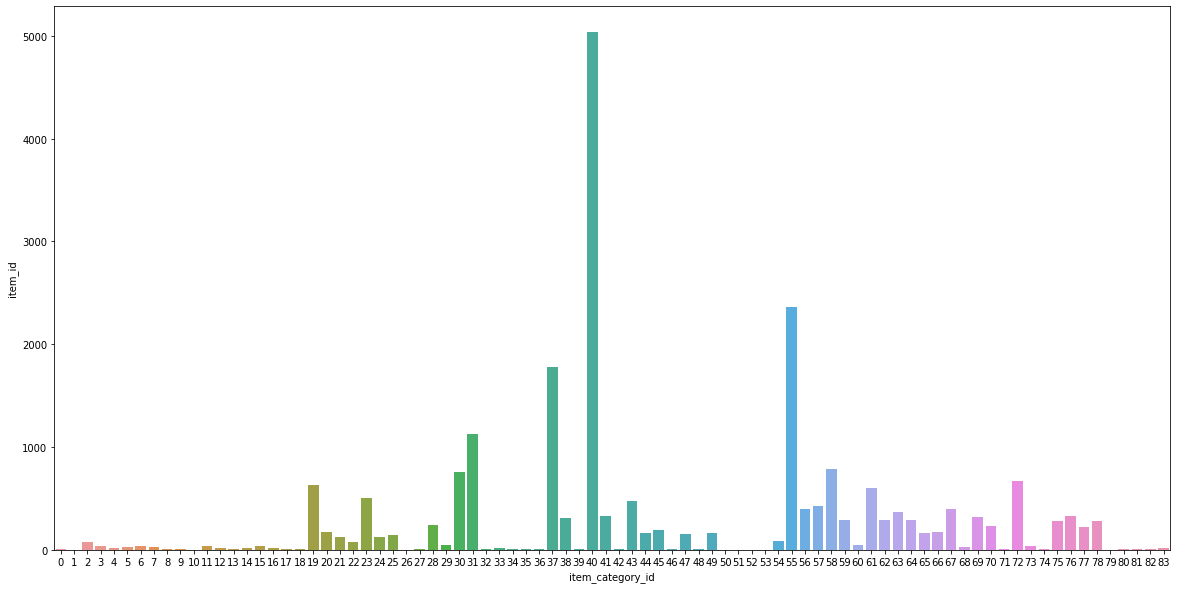

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,10))
sns.barplot(x=item_per_category.index,y='item_id', data=item_per_category)

## 2) shops

In [ ]:
shops['shop_id'].unique()

array([ 0,  1, 57, 58,  5,  6,  7,  8, 15, 17, 18, 19, 36, 37, 38, 42, 43,
       44, 45, 48, 52, 53,  2,  3,  4, 10, 11, 13, 14, 33, 34, 35, 39, 40,
       41, 49, 50, 51, 54, 56, 59,  9, 12, 55, 16, 46, 47, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32])

- shop 은 총 60개가 있습니다.

## 3) sales_train

In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### (1) Shop 별 판매수량 격차 확인

In [ ]:
sales_train.dtypes
sales_train['date']=pd.to_datetime(sales_train['date'])
sales_train['revenue']=sales_train['item_price']*sales_train['item_cnt_day']
sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-02-01,0,59,22154,999.00,1.0,999.00
1,2013-03-01,0,25,2552,899.00,1.0,899.00
2,2013-05-01,0,25,2552,899.00,-1.0,-899.00
3,2013-06-01,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-10-01,0,25,2564,349.00,1.0,349.00
6,2013-02-01,0,25,2565,549.00,1.0,549.00
7,2013-04-01,0,25,2572,239.00,1.0,239.00
8,2013-11-01,0,25,2572,299.00,1.0,299.00
9,2013-03-01,0,25,2573,299.00,3.0,897.00


In [ ]:
shop_sales_count=pd.DataFrame(sales_train.groupby('shop_id').count()['item_cnt_day'])
shop_sales_count.describe()

,item_cnt_day
count,60.000000
mean,48930.416667
std,44691.733115
min,306.000000
25%,20503.750000
50%,42037.500000
75%,58210.250000
max,235630.000000


- 표준편차가 매우 큽니다 (mean 의 95% 수준) 즉,값이 대부분 4000 ~ 200000 에 흩어져있다는 것을 확인 할 수 있습니다. (하단 그래프 : 시각화)

Text(0, 0.5, 'amount of data per shop')

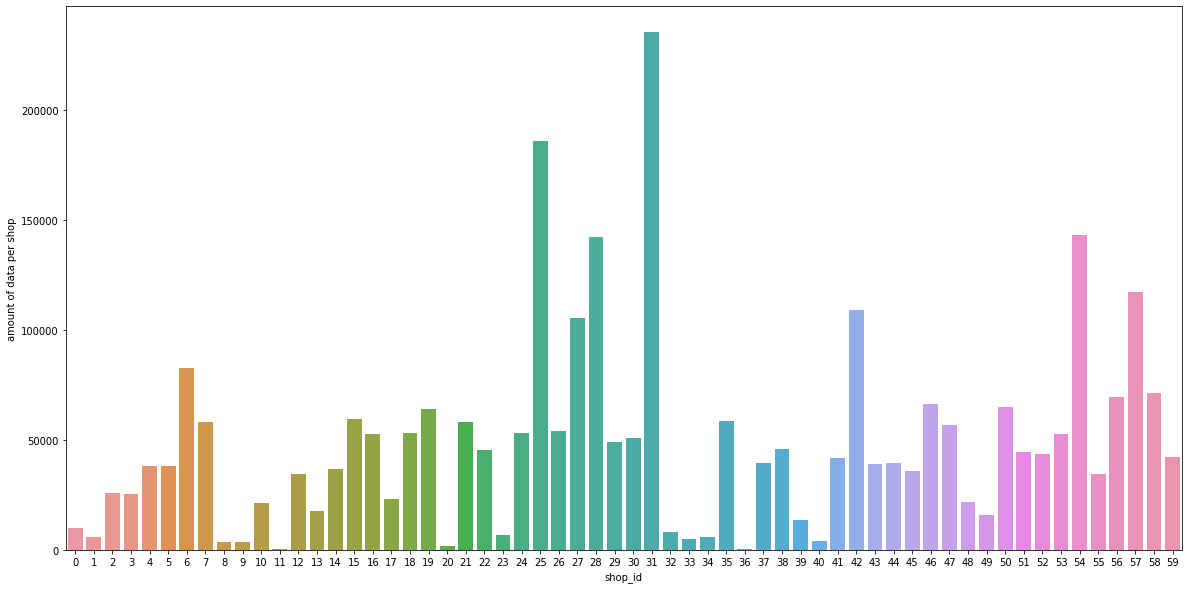

In [ ]:
fig=plt.figure(figsize=(20,10))
sns.barplot(data=shop_sales_count, y='item_cnt_day', x=shop_sales_count.index)
plt.ylabel('amount of data per shop')

### (2) shop별 매출 격차 확인

- 특정 매장만 많은 돈을 벌고 있을까?

In [ ]:
shop_revenue=pd.DataFrame(sales_train.groupby('shop_id').sum()['revenue'])
shop_revenue.head()

,revenue
shop_id,
0,6.637370e+06
1,3.238207e+06
2,4.404964e+07
3,3.014085e+07
4,4.053965e+07


Text(0, 0.5, 'revenue per shop')

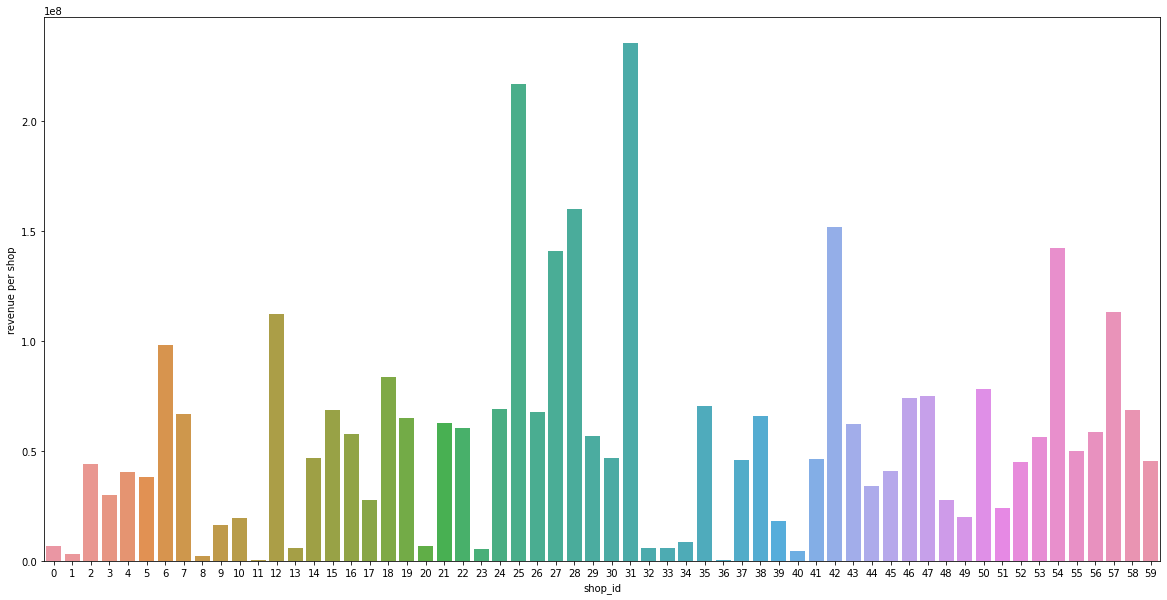

In [ ]:
fig=plt.figure(figsize=(20,10))
sns.barplot(data=shop_revenue, y='revenue', x=shop_revenue.index)
plt.ylabel('revenue per shop')

In [ ]:
shop_revenue.describe()
#revenue 도 아이템 판매량과 유사한 분포로 매우 분산되어있는 모양입니다.

,revenue
count,6.000000e+01
mean,5.664854e+07
std,4.980259e+07
min,3.777140e+05
25%,1.995826e+07
50%,4.671987e+07
75%,6.875614e+07
max,2.352156e+08


### (3) Shop 별 평균 거래액

In [167]:
average_price=pd.DataFrame(sales_train.groupby(['shop_id']).mean()['item_price'])
average_price.describe()
average_price.head()

,item_price
shop_id,
0,563.444151
1,515.350652
2,1350.638391
3,1036.840634
4,923.994318


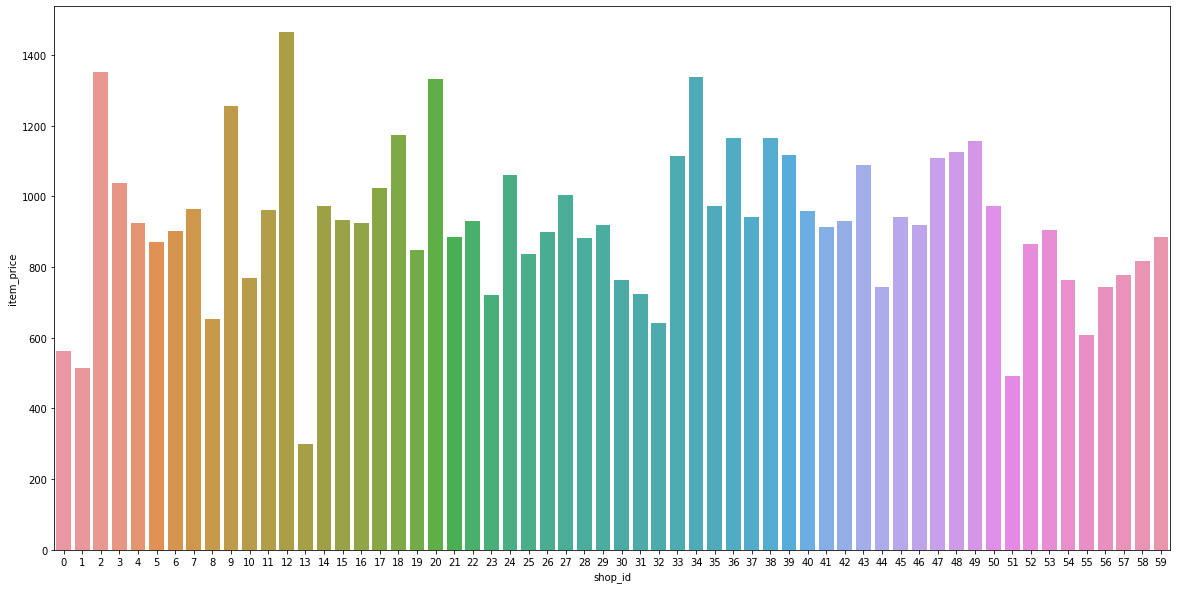

In [168]:
fig=plt.figure(figsize=(20,10))
sns.barplot(data=average_price, x=average_price.index, y=average_price.item_price)

- 각 매장별 각 구매별 평균 거래액은 큰 차이가 나지 않음 
- 평균 925, std 217 = 대부분 700 ~ 1100 (기준화폐) 의 거래량
- 이 말은 각 매장의 성격이 비슷하다는 것으로 확인 가능 (럭셔리 샵이나 저렴한 샵이 있지 않다

### (4) Time series 분포 확인하기

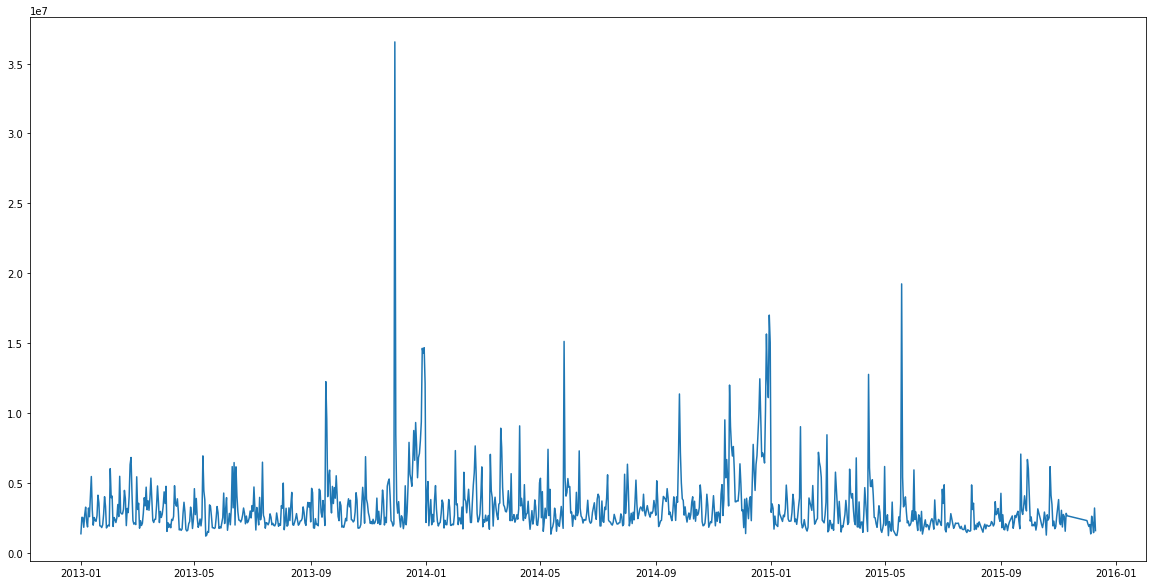

In [170]:
#1. 모든 샵의 세일즈 트렌드

sales_train.groupby('date').sum()['revenue']
fig=plt.figure(figsize=(20,10))
plt.plot(sales_train.groupby('date').sum()['revenue'])
plt.show()

#2. Feature Engineering 

## 1) 매장이 속한 도시별 규모 / Feature of the shop's location (city)

### (1) 파일 골라오기

In [ ]:
shop_english=pd.read_csv("shop_english.csv")
shop_english.head()
shop_english['english shop_name']=shop_english['english shop_name'].str.strip('!')

In [ ]:
city_code=pd.DataFrame(shop_english['english shop_name'].str.split(expand=True), shop_english['shop_id'])

In [ ]:
city_code.replace('St.', 'Saint Petersburg', inplace=True)
city_code.replace('Sergiev', 'Sergiyev Posad', inplace=True)

In [ ]:
city_code.head()
code=pd.Series([i for i in range(60)])
city_code=pd.merge(city_code,code.rename('shop_id'), left_index=True, right_index=True)
city_code.head()

,0,1,2,3,4,5,6,7,shop_id
shop_id,,,,,,,,,
0,Yakutsk,"Ordzhonikidze,",56,Franc,None,None,None,None,0
1,Yakutsk,TC,"""Central""",Franc,None,None,None,None,1
2,Adygea,TC,"""Mega""",None,None,None,None,None,2
3,Balashikha,TRC,"""October-Kinomir""",None,None,None,None,None,3
4,Volzhsky,mall,"""Volga","Mall""",None,None,None,None,4


In [ ]:
city_code.head() #매장 이름을 parsing

,0,1,2,3,4,5,6,7,shop_id
shop_id,,,,,,,,,
0,Yakutsk,"Ordzhonikidze,",56,Franc,None,None,None,None,0
1,Yakutsk,TC,"""Central""",Franc,None,None,None,None,1
2,Adygea,TC,"""Mega""",None,None,None,None,None,2
3,Balashikha,TRC,"""October-Kinomir""",None,None,None,None,None,3
4,Volzhsky,mall,"""Volga","Mall""",None,None,None,None,4


In [ ]:
city_info=pd.read_csv('ru.csv') # 도시에 대해 조사한 사항 csv 업로드

In [ ]:
city_info.head() 
city_info['capital'].fillna('Other', inplace=True)

In [ ]:
city_info.drop(['lat', 'lng', 'country', 'admin', 'population_proper', 'iso2'], axis=1, inplace=True) #위도, 경도, 국가 등은 제거

In [ ]:
city_info.head() 

,city,capital,population
0,Moscow,primary,10452000.0
1,Saint Petersburg,admin,4553000.0
2,Novosibirsk,admin,1389000.0
3,Yekaterinburg,admin,1313000.0
4,Nizhniy Novgorod,admin,1278000.0


In [ ]:
city_merge=pd.merge(city_code,city_info, left_on=0, right_on='city',  how='left')

In [ ]:
shops=city_merge[[0,'shop_id', 'city', 'capital', 'population']]
shops.head()

,0,shop_id,city,capital,population
0,Yakutsk,0,Yakutsk,admin,235600.0
1,Yakutsk,1,Yakutsk,admin,235600.0
2,Adygea,2,Adygea,Common wealth,439996.0
3,Balashikha,3,Balashikha,Common wealth,228567.0
4,Volzhsky,4,Volzhsky,Common wealth,320761.0


### (2) Categorical encoding

In [ ]:
lista=[]
shops=city_merge[[0,'shop_id', 'city', 'capital', 'population']]
for i,v in enumerate(shops['city'].unique()):
  lista.append((i,v))
df=pd.DataFrame(lista, columns=['city_code', 'city'])
shops=pd.merge(df, shops)
shops=shops[['shop_id','city_code', 'capital', 'population']]

lista=[]
for i,v in enumerate(shops['capital'].unique()):
  lista.append((i,v))
df=pd.DataFrame(lista, columns=['capital_code', 'capital'])
shops=pd.merge(shops, df)


In [ ]:
shops=shops[['shop_id', 'city_code', 'population', 'capital_code']]
shops.head()

,shop_id,city_code,population,capital_code
0,0,0,235600.0,0
1,1,0,235600.0,0
2,57,0,235600.0,0
3,58,0,235600.0,0
4,5,4,294889.0,0


In [ ]:
monthly_tmp=pd.read_csv("Ru_monthly_temperature.csv")

## 2) Holiday - 러시아의 국경일

- 국경일의 경우 소비자의 여가 시간이 길어져서 소비 활동도 늘 것으로 가정 

In [ ]:
holiday=pd.read_csv("Ru_Public_holiday.csv")

In [ ]:
holiday=holiday[['Month', 'Number of days']]

In [ ]:
holiday.head()
holiday.to_csv('holiday_v2.csv')
monthly_tmp.to_csv('monthly_tmp_v2.csv')

## 3) 기온

- 월 평균 기온이 높다면 실내활동이 많아져 독서, 비디오 시청에 대한 수요가 증가할 것으로 예상

In [ ]:
monthly_tmp=monthly_tmp[['Month', 'temperature']]

In [ ]:
monthly_tmp.head()

,Month,temperature
0,1,-7.5
1,2,-6.5
2,3,-1.5
3,4,6.5
4,5,13.5


In [ ]:
Ru_city_temp

## 4) 아이템 카테고리

- 카테고리 소분류, 대분류 추가

In [ ]:
item_id_to_cate_id = {i:v for i,v in zip(items['item_id'],items['item_category_id'])}
cate_id_to_L_cate = { i:v for i,v in zip(item_categories_add['item_category_id'],item_categories_add['item_category_name_L'])}

In [ ]:
sales_train['item_category_id'] = sales_train['item_id'].map(item_id_to_cate_id)
sales_train['item_category_name_L'] =sales_train['item_category_id'].map(cate_id_to_L_cate)

In [ ]:
# sales_train['item_category_id'] 소분류 인덱싱 되어있음
# sales_train['item_category_name_L'] 대분류 인덱싱 안 되어있음

In [ ]:
#sales_train['item_category_name_L'] = pd.Categorical(item_category_name_L).codes

NameError: ignored

## 5) 이동평균/지수이동평균


In [ ]:
from itertools import product
import numpy as np 
# create all combinations 
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])

shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])

all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner') # group by monthly

train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left') 

train_base['item_cnt_day'].fillna(0, inplace=True)
 
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])


In [ ]:
#summary count by month
# 한달단위의 팔린 갯수 및 주문 수
# 극단 값들을 0,20사이의 값들로 만들어준다. 

train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index() 

train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order'] 

print(train_monthly[['item_cnt','item_order']].describe()) 
# trim count 

train_monthly['item_cnt'].clip(0, 20, inplace=True) 
train_grp.head()


           item_cnt    item_order
count  7.282800e+06  7.282800e+06
mean   1.997350e-02  1.008310e+00
std    8.419160e-01  2.295656e-01
min   -2.000000e+00  1.000000e+00
25%    0.000000e+00  1.000000e+00
50%    0.000000e+00  1.000000e+00
75%    0.000000e+00  1.000000e+00
max    7.660000e+02  3.100000e+01


,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
0,0,5,5037,NaN,NaN,0.0
1,0,5,5320,NaN,NaN,0.0
2,0,5,5233,NaN,NaN,0.0
3,0,5,5232,NaN,NaN,0.0
4,0,5,5268,NaN,NaN,0.0
...,...,...,...,...,...,...
7343314,33,45,18454,NaN,NaN,0.0
7343315,33,45,16188,NaN,NaN,0.0
7343316,33,45,15757,NaN,NaN,0.0
7343317,33,45,19648,NaN,NaN,0.0


In [ ]:
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], 
                                      columns=['date_block_num'], 
                                      values='item_cnt', aggfunc=np.sum, fill_value=0) 
train_piv = train_piv.reset_index() 
train_piv.head()

In [ ]:
# 이동평균과 지수평균 앞의 12개월은 지운다. 
col = np.arange(34) 
pivT = train_piv[col].T 
mov_s = pivT.rolling(3).mean().T 
mov_m = pivT.rolling(6).mean().T 
mov_l = pivT.rolling(12).mean().T 
ema_s = pivT.ewm(span=3).mean().T 
ema_m = pivT.ewm(span=6).mean().T 
ema_l = pivT.ewm(span=9).mean().T
ema_xl = pivT.ewm(span=12).mean().T 
 
ema_list = []
col_select = np.arange(11,34) 
for c in col_select: 
    sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']], 
                         pd.DataFrame(mov_s.loc[:,c]).rename(columns={c:'cnt_mov_s_prev'}), 
                         pd.DataFrame(mov_m.loc[:,c]).rename(columns={c:'cnt_mov_m_prev'}), 
                         pd.DataFrame(mov_l.loc[:,c]).rename(columns={c:'cnt_mov_l_prev'}),
                         pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}), 
                         pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}), 
                         pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
                         pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_xl_prev'})],
                         axis=1) 
    sub_ema['date_block_num'] = c 
    ema_list.append(sub_ema) 

train_ema_prev = pd.concat(ema_list) 
train_ema_prev.head()


,shop_id,item_id,cnt_mov_s_prev,cnt_mov_m_prev,cnt_mov_l_prev,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_ema_xl_prev,date_block_num
0,2,30,0.0,0.0,0.166667,0.008791,0.052704,0.085122,0.085122,11
1,2,31,0.0,0.0,0.500000,0.004884,0.074004,0.157093,0.157093,11
2,2,32,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,11
3,2,33,0.0,0.0,0.083333,0.000244,0.007182,0.018448,0.018448,11
4,2,38,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,11


# 3. Modeling

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def mergeFeature(df): 
    df = pd.merge(df, shop_id, on=['shop_id'], how='left')
    df['Month'] = df['date_block_num'] % 12 +1
    df = pd.merge(df, monthly_tmp, on=['Month'], how='left') 
    df = pd.merge(df, holiday, on=['Month'], how='left') 
    df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id']
                  , how='left')

    df.drop(['shop_id','item_id'], axis=1, inplace=True) 
    df.fillna(0.0, inplace=True)


    return reduce_mem_usage(df)


train_set = train_monthly[train_monthly['date_block_num'] >= 11]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
 
train_set = mergeFeature(train_set) 
train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column 
X_train = train_set.drop(['item_cnt'], axis=1) 
Y_train = train_set['item_cnt'].clip(0.,20.) 
X_train.head()


In [ ]:

X_train.head()

train_price_a.shape

test_set = test.copy() 
test_set['date_block_num'] = 34 
test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left') 
test_set = mergeFeature(test_set) 
test_set['item_order'] = test_set['cnt_ema_s_prev']
#order_prev 
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1 
X_test = test_set.drop(['ID'], axis=1) 
X_test.head() 
assert(X_train.columns.isin(X_test.columns).all())


from sklearn import linear_model, preprocessing 
from sklearn.model_selection import GroupKFold 
import lightgbm as lgb 
params={'learning_rate': 0.05, 
        'objective':'regression', 
        'metric':'rmse', 
        'num_leaves': 64, 
        'verbose': 1, 
        'random_state':42, 
        'bagging_fraction': 1, 
        'feature_fraction': 1 
       , 'n_jobs':-1} 
folds = GroupKFold(n_splits=6) 
oof_preds = np.zeros(X_train.shape[0]) 
sub_preds = np.zeros(X_test.shape[0])


for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])): 
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_] 
    val_x, val_y = X_train.iloc[val_], Y_train[val_] 
    reg = lgb.LGBMRegressor(**params, n_estimators=3000) 
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500) 
    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_) 
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits



pred_cnt = sub_preds 
result = pd.DataFrame({ "ID": test["ID"], "item_cnt_month": pred_cnt.clip(0. ,20.) }) 
result.to_csv("./submission.csv", index=False)
